In [88]:
# info about VM.
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm

import cv2

plt.rc('font', weight='bold')
sns.set_style("whitegrid")

print(f"Python version = {sys.version}")
print(f"Numpy version = {np.__version__}")
print(f"OpenCV version = {cv2.__version__}")

Python version = 3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy version = 1.19.5
OpenCV version = 4.5.1


# Dataset : 

NIH Dataset images available at : "/media/HHD2/NIH/tflow_obj_detection/images"

Metadata for NIH is available at : "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"

In [90]:
DATASET_PATH = "/media/HHD2/NIH/tflow_obj_detection/images/"
METADATA_PATH = "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"

In [91]:
df = pd.DataFrame(pd.read_csv(METADATA_PATH))

print(f"Shape of the dataframe = {df.shape}")
print(f"Number of images found = {len(os.listdir(DATASET_PATH))}")

Shape of the dataframe = (112120, 11)
Number of images found = 112120


In [92]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


Check for missing entries.

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


So, we don't have any missing entry in the metadata file. 

# Basic Functions For Image Loading & Resizing.

Also the images are essentially grayscale(*actually grayscale stacked behind one another to form a 3-D tensor*). Hence, we skip the BGR2RGB argument during image reading, via OpenCV.

In [94]:
def load_image(base_path, image_name) : 
    image_path = os.path.join(base_path, image_name)
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [95]:
def resize_image(image, image_size) : 
    image = cv2.resize(image, (image_size[0], image_size[1]), interpolation = cv2.INTER_AREA)
    return image

## Load Some Images : 

In [96]:
random_image_names = [np.random.choice(os.listdir(DATASET_PATH)) for i in range(9)]

random_image_names

['00010799_001.png',
 '00014294_001.png',
 '00003548_001.png',
 '00020224_001.png',
 '00001295_000.png',
 '00024888_000.png',
 '00007018_039.png',
 '00010888_003.png',
 '00013285_032.png']

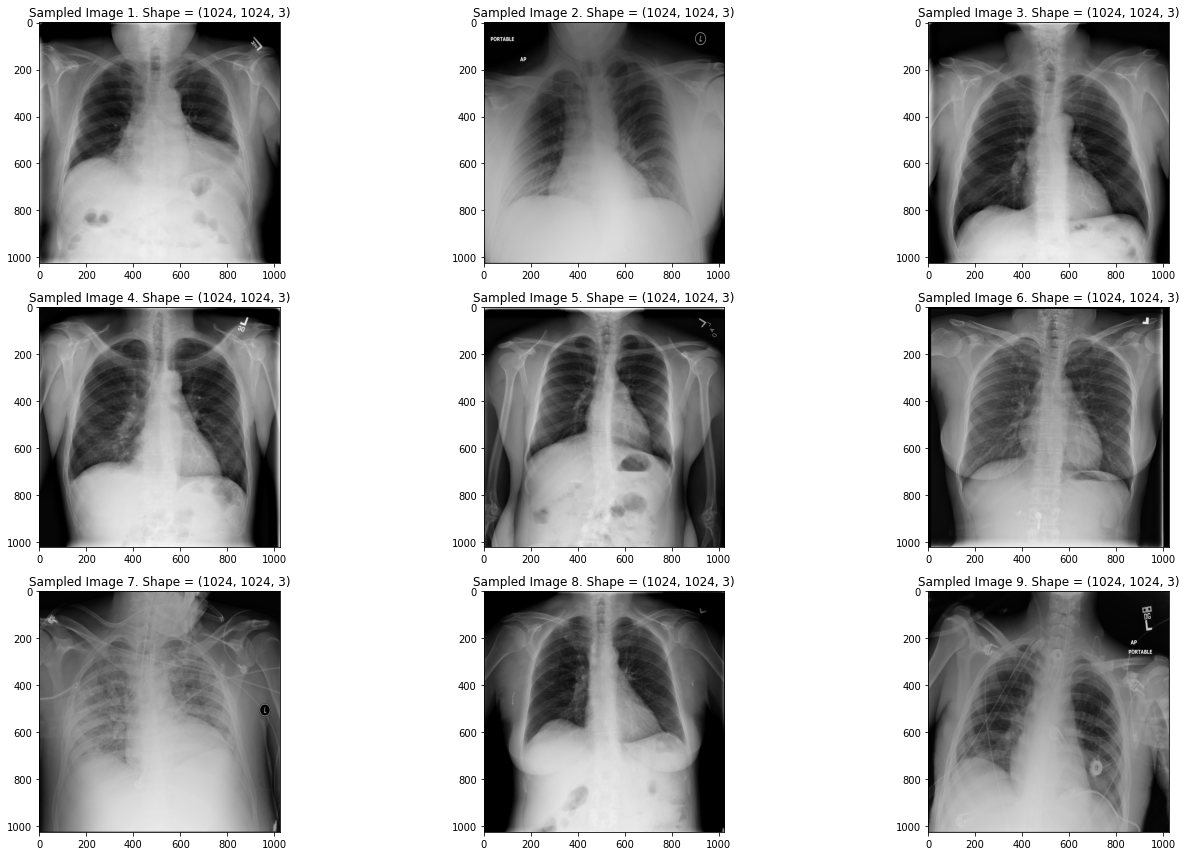

In [97]:
plt.figure(figsize = (20, 12))
for i in range(9) : 
    plt.subplot(3, 3, i+1)
    image = load_image(DATASET_PATH, random_image_names[i])
    plt.title(f"Sampled Image {i + 1}. Shape = {image.shape}")
    plt.imshow(image)
    plt.grid(False)

plt.tight_layout()

# Need For EDA : 

When we’re getting started with a machine learning (ML) project, one critical principle to keep in mind is that data is everything. It is often said that if ML is the rocket engine, then the fuel is the (high-quality) data fed to ML algorithms. However, deriving truth and insight from a pile of data can be a complicated and error-prone job. To have a solid start for our ML project, it always helps to analyze the data up front.

During EDA, it’s important that we get a deep understanding of:

* The properties of the data, such as schema and statistical properties;
* The quality of the data, like missing values and inconsistent data types;
* The predictive power of the data, such as correlation of features against target.

In [79]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


Analyze which view positions we have.

In [80]:
df["View Position"].unique()

array(['PA', 'AP'], dtype=object)

So, all images are either PA or AP oriented. So, no lateral images.

**Drop useless features**

In [81]:
df = df[["Image Index", "Finding Labels", "Patient ID", "Patient Age", "Patient Gender"]]

df.head()

,Image Index,Finding Labels,Patient ID,Patient Age,Patient Gender
0,00000001_000.png,Cardiomegaly,1,57,M
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,M
2,00000001_002.png,Cardiomegaly|Effusion,1,58,M
3,00000002_000.png,No Finding,2,80,M
4,00000003_001.png,Hernia,3,74,F


## Extract Nodular and Healthy Images : 

We will initially train a binary classifier, in order to detect nodules from healthy images. Hence, from metadata, we filter out images thjat satisfy either criteria.

We will extract each row by *iloc attribute*, and check if any of the label matches with what we want. Post that, we will assign **1 for Nodule and 0 for normal cases**, in case a label we're interested in is located in that row entry. 

Normally, one-hot encoding is preferred, however I read that sometimes model assumes to give priority when it sees sparse labels. For example, it might think that label 1 is more important than 0. This is advantageous in our case, as we want model to give higher priority to nodule identification in healthy images. In multi-classes, I would have gone for one-hot straight away.

The rows which encapsulates the labels we are seeking are added in a *filtered_list*, which is converted into a dataframe, in the end.

In [82]:
"""
labels = ["Nodule", "No Finding"]
size = df.shape[0]

filtered_list = []

for i in tqdm(range(size)) : 
    row = df.iloc[i].values
    flag = False
    for label in labels : 
        if label in row[1] : 
            if label == "Nodule" : 
                row[1] = 1 
            else : 
                row[1] = 0
            flag = True
            break
    if flag == True :
        filtered_list.append(row)

# convert filtered list to dataframe
df = pd.DataFrame(filtered_list, columns = ['image_id', 'label', 'patient_id', 'age', 'gender'])

print(f"Shape of filtered dataframe = {df.shape}")
df.head()
"""

  0%|          | 0/112120 [00:00<?, ?it/s]

Shape of filtered dataframe = (66692, 5)


,image_id,label,patient_id,age,gender
0,00000002_000.png,0,2,80,M
1,00000004_000.png,1,4,82,M
2,00000005_000.png,0,5,69,F
3,00000005_001.png,0,5,69,F
4,00000005_002.png,0,5,69,F


Save the CSV for future use.

In [83]:
"""
# save csv
os.mkdir("filtered_metadata")
df.to_csv(r"filtered_metadata/metadata.csv", index = False)
"""

Load the saved CSV.

* Label 1 indicates Nodule presence.
* Label 0 indicates healthy image.

In [107]:
df = pd.DataFrame(pd.read_csv("filtered_metadata/metadata.csv"))

print(f"Shape of metadata = {df.shape}")
df.head()

Shape of metadata = (66692, 5)


,image_id,label,patient_id,age,gender
0,00000002_000.png,0,2,80,M
1,00000004_000.png,1,4,82,M
2,00000005_000.png,0,5,69,F
3,00000005_001.png,0,5,69,F
4,00000005_002.png,0,5,69,F


# Nodule V Healthy Distribution Analysis

In [108]:
d = dict()
for l in tqdm(df["label"].values) : 
    if l not in d : 
        d[l] = 1
    else:
        d[l] += 1

print(d)

  0%|          | 0/66692 [00:00<?, ?it/s]

{0: 60361, 1: 6331}


(-1.1219028743122497,
 1.0926519012491858,
 -1.1579848040301235,
 1.1528299728812894)

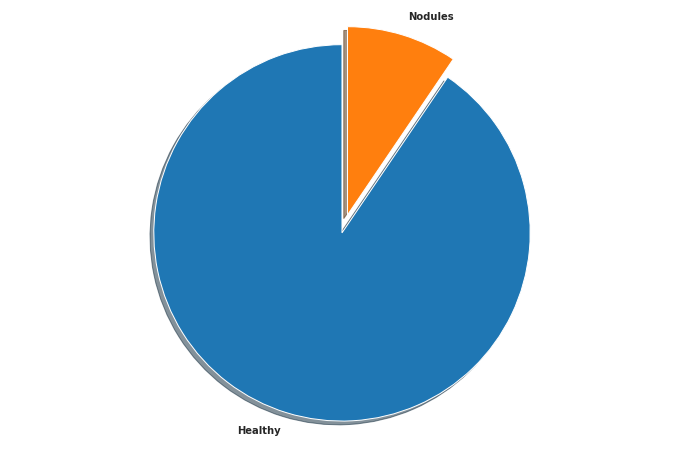

In [109]:
labels = ["Healthy", "Nodules"]
counts = [d[0], d[1]]

explode = (0.05, 0.05)
fig, ax = plt.subplots(figsize = (12, 8))
ax.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
ax.axis("equal")

**Heavily skewed**! 

I will use **stratified sampling** later, to split it into validation, training and testing TFRecords.

# Age Analysis

Mean age of the distribution of diagnosed patients= 45.84 

Standard Deviation age of the distribution of diagnosed patients= 16.46 



<Figure size 1440x1440 with 0 Axes>

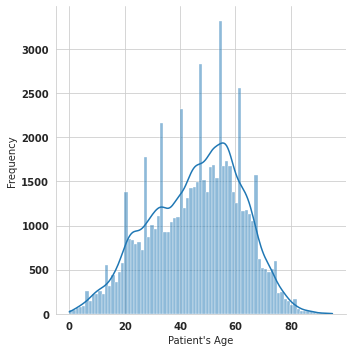

In [138]:
print("Mean age of the distribution of diagnosed patients= {:.2f} \n".format(np.mean(df["age"].values)))
print("Standard Deviation age of the distribution of diagnosed patients= {:.2f} \n".format(np.std(df["age"].values)))
plt.figure(figsize = (20, 20))

fig = sns.displot(data = df, x = "age", kde = True)
fig.set(xlabel = "Patient's Age", ylabel = "Frequency")
plt.grid(True)

A good fraction of our patients are b/w 40-60 years of age.

Next, have a look at age of the patients having nodules.

In [139]:
nodule_segment = df[df["label"] == 1]

nodule_segment.shape
nodule_segment.head(2)

,image_id,label,patient_id,age,gender
1,00000004_000.png,1,4,82,M
11,00000008_002.png,1,8,72,F


Mean age of the distribution of diagnosed patients= 49.25 

Standard Deviation age of the distribution of diagnosed patients= 15.34 



<Figure size 1440x1440 with 0 Axes>

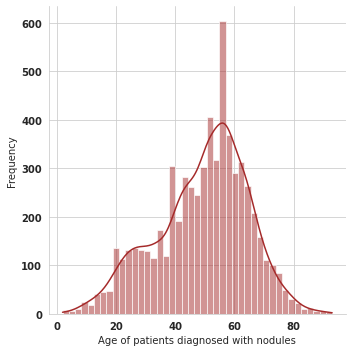

In [140]:
print("Mean age of the distribution of diagnosed patients= {:.2f} \n".format(np.mean(nodule_segment["age"].values)))
print("Standard Deviation age of the distribution of diagnosed patients= {:.2f} \n".format(np.std(nodule_segment["age"].values)))

plt.figure(figsize = (20, 20))

fig = sns.displot(data = nodule_segment, x = "age", kde = True, color = "brown")
fig.set(xlabel = "Age of patients diagnosed with nodules", ylabel = "Frequency")
plt.grid(True)

Healthy Patient Case : 

In [141]:
healthy_segment = df[df["label"] == 0]

healthy_segment.shape
healthy_segment.head(2)

,image_id,label,patient_id,age,gender
0,00000002_000.png,0,2,80,M
2,00000005_000.png,0,5,69,F


Mean age of the distribution of healthy patients= 45.48 

Standard Deviation age of the distribution of healthy patients= 16.53 



<Figure size 1440x1440 with 0 Axes>

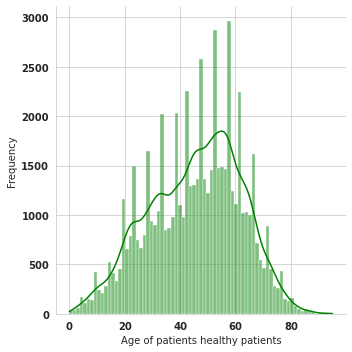

In [142]:
print("Mean age of the distribution of healthy patients= {:.2f} \n".format(np.mean(healthy_segment["age"].values)))
print("Standard Deviation age of the distribution of healthy patients= {:.2f} \n".format(np.std(healthy_segment["age"].values)))

plt.figure(figsize = (20, 20))

fig = sns.displot(data = healthy_segment, x = "age", kde = True, color = "green")
fig.set(xlabel = "Age of patients healthy patients", ylabel = "Frequency")
plt.grid(True)

**Inference** : 
* The mean and standard deviation for both healthy and diagnosed patients is comparable and within each other's hair. Hence, considering this as a feature to distinguish between them might not give the best results.